# Time Series Analysis Exercise 2: Wholesale Price Index Forecasting

In this exercise we will practice time series analysis and forecasting on a dataset of historical USA [Wholesale Price Index](https://www.investopedia.com/terms/w/wpi.asp) values. We are interested in predicting the upcoming WPI value given the history of WPI values until a given time.

This exercise requires the `statsmodels` library, available by default in Google Colab and Anaconda and which can be installed with `pip install statsmodels`.

**Questions:**
1. Load `wholesale_price_index.csv` into a dataframe `df`. Use arguments `parse_dates=` and `index_col=` with `pd.read_csv()` so that the dates are used as the DataFrame index. Is the data evenly spaced, and if so, what time interval is used?

In [1]:
import pandas as pd

# Load the CSV file into a DataFrame with dates as index
df = pd.read_csv('wholesale_price_index.csv')
df.head()

,wpi,t,ln_wpi
0,30.7,1960-01-01,3.424263
1,30.8,1960-04-01,3.427515
2,30.7,1960-07-01,3.424263
3,30.7,1960-10-01,3.424263
4,30.8,1961-01-01,3.427515


In [2]:
# Load the CSV file into a DataFrame with dates as index
df = pd.read_csv('wholesale_price_index.csv', parse_dates=['t'], index_col='t')
display(df.head())
print(df.shape)
display(df.tail())

,wpi,ln_wpi
t,,
1960-01-01,30.7,3.424263
1960-04-01,30.8,3.427515
1960-07-01,30.7,3.424263
1960-10-01,30.7,3.424263
1961-01-01,30.8,3.427515


(124, 2)


,wpi,ln_wpi
t,,
1989-10-01,109.4,4.695011
1990-01-01,111.0,4.709530
1990-04-01,110.8,4.707727
1990-07-01,112.8,4.725617
1990-10-01,116.2,4.755313


We have 124 rows in the data, 4 rows per year, first year is 1960 and last year 1990, that is 31 years, 31*4 = 124 so the data is evenly spaced and the interval is 3 months, over 30 years.


2. We will only be using the `ln_wpi` column for this exercise, which contains **log-scaled** Wholesale Price Index values. Save `ln_wpi` values for years before 1984 in `wpi_train` and `ln_wpi` values for years at and after 1984 in `wpi_test`.

In [3]:
wpi_train = df.loc[df.index.year < 1984, 'ln_wpi']
wpi_test = df.loc[df.index.year >= 1984, 'ln_wpi']


3. Plot the values of `wpi_train` and `wpi_train.diff()` in separate line plots. What do these represent?


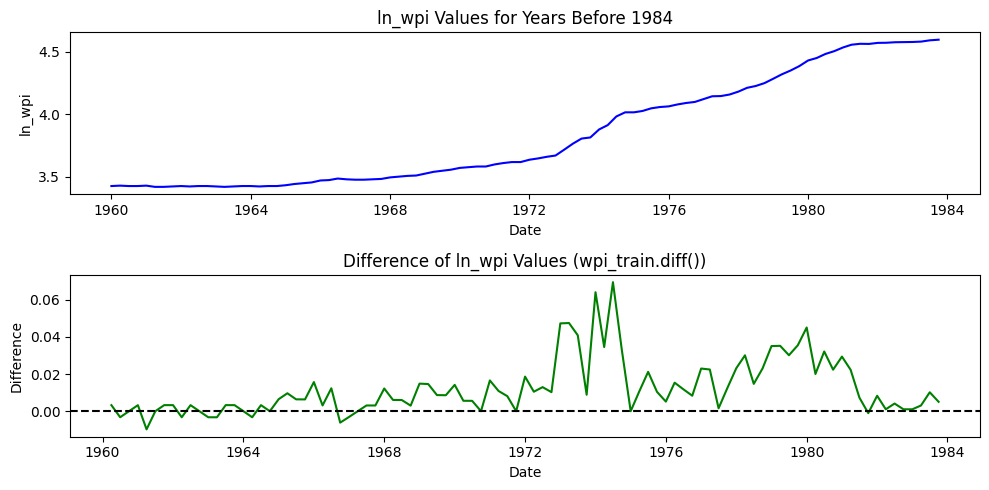

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.subplot(2, 1, 1)
plt.plot(wpi_train.index, wpi_train, color='blue')
plt.title('ln_wpi Values for Years Before 1984')
plt.xlabel('Date')
plt.ylabel('ln_wpi')

plt.subplot(2, 1, 2)
plt.plot(wpi_train.index, wpi_train.diff(), color='green')
plt.title('Difference of ln_wpi Values (wpi_train.diff())')
plt.xlabel('Date')
plt.ylabel('Difference')
plt.axhline(0, color='black', linestyle='--')  # Add horizontal line at y=0 for reference
plt.tight_layout()

plt.show()


The first plot represents the original ln_wpi values for years before 1984.

The second plot represents the difference of ln_wpi values, which calculates the first discrete difference of the series. This shows the changes or increments in the ln_wpi values from one time point to the next. 

4. Evaluate a baseline naive (random walk) model as follows:
  * For each sample $y_t$ in `wpi_test`, the baseline prediction is $\hat{y}_t = y_{t-1}$, i.e. use the previous ground truth at time $t-1$ as the prediction for time $t$.
  * Calculate the RMSE of the predictions $\hat{y}_t$ versus the ground truth values $y_t$ over the test set `wpi_test`.


In [5]:
import numpy as np
from sklearn.metrics import mean_squared_error

predictions = []

for i in range(1, len(wpi_test)):
    predictions.append(wpi_test.iloc[i-1])

rmse = np.sqrt(mean_squared_error(wpi_test[1:], predictions))

print("RMSE of the baseline naive model:", rmse)

RMSE of the baseline naive model: 0.012194251784466452


5. Plot the predictions from the last question on top of the observed values for `wpi_test`. Make sure the x axis in the plot is the time index and that $y_t$ and $\hat{y}_t$ are aligned correctly. Include the RMSE value in the title of the plot.


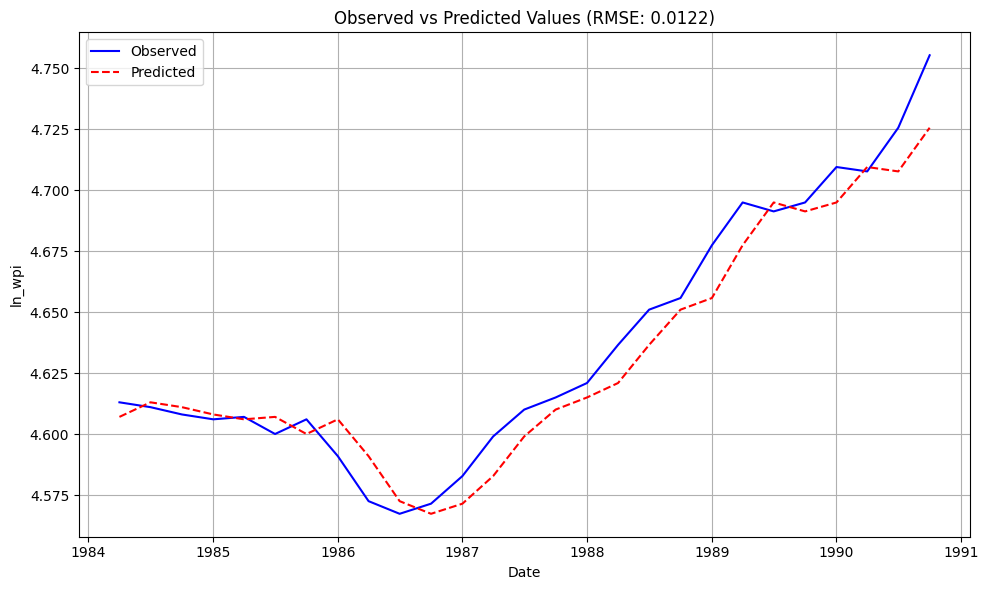

In [6]:
plt.figure(figsize=(10, 6))
plt.plot(wpi_test.index[1:], wpi_test[1:], label='Observed', color='blue')
plt.plot(wpi_test.index[1:], predictions, label='Predicted', color='red', linestyle='--')
plt.title(f'Observed vs Predicted Values (RMSE: {rmse:.4f})')
plt.xlabel('Date')
plt.ylabel('ln_wpi')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

6. We will be treat the series as integrated of order one, i.e. using an ARIMA(p,1,q) model. This assumes that the first finite difference of the series is stationary. Using your answer to 3, explain why this makes *more* sense than an ARIMA(p,0,q) model.


Using ARIMA(p,1,q) Makes More Sense because  As we saw, the data exhibits trends, seasonality, and non-stationary behavior.
    First differencing removes non-stationary components, focusing on stationary fluctuations.
    ARIMA(p,1,q) suits data with trends or non-stationary behavior, better capturing dynamics.


7. Using the `plot_acf` and `plot_pacf` functions from the `statsmodels` library, plot the ACF and the PACF of `wpi_train.diff()`. Make sure to drop NaN values so that the plots display correctly. Note: you may add a semicolon (;) at the end of the code to avoid double-printing the graphs.


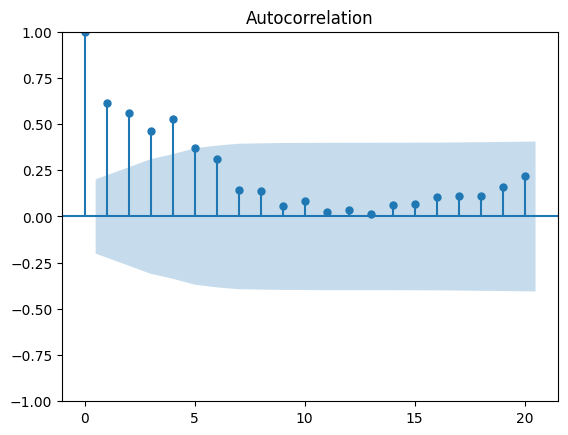

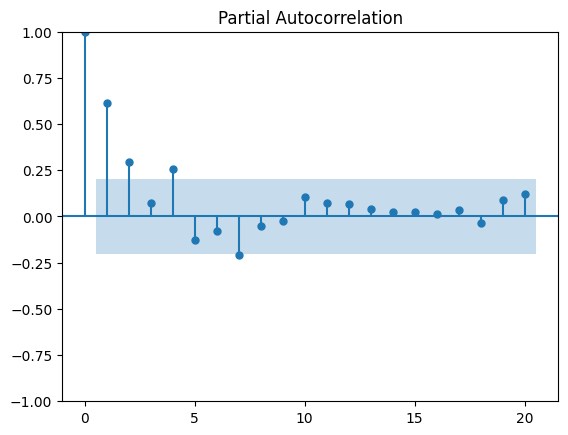

In [7]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

wpi_train_diff = wpi_train.diff().dropna()

plot_acf(wpi_train_diff);

plot_pacf(wpi_train_diff);

8. We will model our data using an ARIMA(4,1,0) model. Explain the orders p=4 and q=0 of this model using what you see in the graphs from the previous question. An approximate/ballpark answer is fine.


In an ARIMA(4,1,0) model:

The order p=4 indicates that the autoregressive component of the model considers the last four lags of the differenced series. This is suggested by the significant spikes or decaying autocorrelation observed in the partial autocorrelation function (PACF) plot at lag 1, 2, 3, and 4, indicating that the previous four observations have some influence on the current value, as we can see in PACF plot.

The order q=0 indicates that there are no moving average terms included in the model. This is inferred from the autocorrelation function (ACF) plot, where there are no significant spikes beyond lag 0. 

9. Use an Arima(4,1,0) model to forecast values of `wpi_test` and compare its predictions to the observed data as follows:
  * Set `history = wpi_train.to_list()` and `predictions = []`
  * For each time step `t in range(len(wpi_test))` do the following:
    * Train an ARIMA model on `history` using `model = ARIMA(..., order=...)` from `statsmodels.tsa.arima_model` (or `arima.model` if using version >= 0.12 of statsmodels).
    * Fit the model with `model_fit = model.fit()`.
    * Predict the next WPI using  `model_fit.forecast()` and append it to `predictions`.
    *  Append the `t`-th element of `wpi_test` to `history`.


In [8]:
from statsmodels.tsa.arima.model import ARIMA

history = wpi_train.to_list()
predictions = []

for t in range(len(wpi_test)):
    model = ARIMA(history, order=(4,1,0))
    model_fit = model.fit()
    next_wpi = model_fit.forecast()[0]
    predictions.append(next_wpi)
    history.append(wpi_test.iloc[t])

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


10. For `model_fit` from the final time step, run and examine the output of `model_fit.summary()` (you do not need to explain the output).


In [9]:
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  123
Model:                 ARIMA(4, 1, 0)   Log Likelihood                 380.822
Date:                Sun, 18 Feb 2024   AIC                           -751.643
Time:                        18:46:15   BIC                           -737.623
Sample:                             0   HQIC                          -745.949
                                - 123                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4146      0.073      5.716      0.000       0.272       0.557
ar.L2          0.1944      0.087      2.242      0.025       0.024       0.364
ar.L3          0.0351      0.074      0.475      0.6

11. Plot the predictions from the last question on top of the observed values for `wpi_test`. What is the RMSE of these predictions? Include it in the title of the plot.


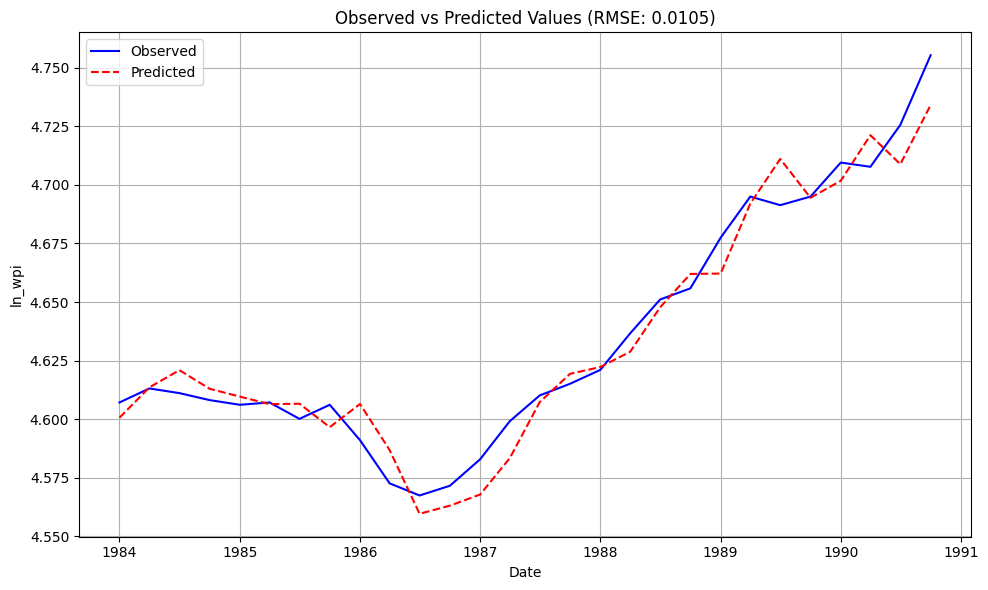

In [10]:
rmse = np.sqrt(mean_squared_error(wpi_test, predictions))

plt.figure(figsize=(10, 6))
plt.plot(wpi_test.index, wpi_test, label='Observed', color='blue')
plt.plot(wpi_test.index, predictions, label='Predicted', color='red', linestyle='--')
plt.title(f'Observed vs Predicted Values (RMSE: {rmse:.4f})')
plt.xlabel('Date')
plt.ylabel('ln_wpi')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

12. How do the forecasts of our ARIMA model compare to the naive baseline?


We can see that our Arima model is slightly better by nothing (rmse of 0.0105 for ARIMA compared to 0.0122), this shows how this simple naive baseline is efficient and how hard it is to create a model having significantly better results with this kind of data.

13. (BONUS) The method we used above of retraining the model and calculating a new forecast at each step is called "time series cross-validation" or the "rolling origin" method.* Another option is to only train the model on the training data, and use the model's forecasts to predict subsequent samples. Try training and comparing baseline and ARIMA(4, 1, 0) models on the data with this procedure. Tips:
    * The baseline naive model will just predict the last value from `wpi_train` for every sample.
    * In forecasting with the ARIMA model, you do not need to use a loop. Just use `.forecast(steps=...)`. See [the statsmodels documentation](https://www.statsmodels.org/v0.11.1/generated/statsmodels.tsa.arima_model.ARMAResults.forecast.html) for more details.

  Is the ARIMA model better than the baseline using this procedure?

*(See Hyndman, R.J., & Athanasopoulos, G. (2018) [Forecasting: principles and practice, section 3.4](https://otexts.com/fpp2/accuracy.html))

In [11]:
# your code here